In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Chuẩn bị dữ liệu

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'qunguynthanhthin'
os.environ['KAGGLE_KEY'] = 'a2cb32bf72cd4d38e1720503ce0813eb'
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data"

In [ ]:
%cd /content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data

/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data


In [ ]:
# !kaggle datasets download -d awsaf49/brats20-dataset-training-validation

100% 4.16G/4.16G [02:29<00:00, 33.9MB/s]
100% 4.16G/4.16G [02:29<00:00, 29.9MB/s]


In [ ]:
# import zipfile
# zip_ref = zipfile.ZipFile("/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/BraTS2020_TrainingData.zip", 'r')
# zip_ref.extractall("/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/")
# zip_ref.close()

In [ ]:
import tarfile
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# file = tarfile.open('/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/BraTS2021_00621.tar')
# file.extractall('/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/MRI/')

In [ ]:
# file = tarfile.open('/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/BraTS2021_00495.tar')
# file.extractall('/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/MRI/')

## Show vài ảnh

In [ ]:
!pip install SimpleITK

In [ ]:
import SimpleITK as sitk

In [ ]:
image = sitk.ReadImage('/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/MRI/BraTS2021_00621_t1ce.nii.gz')
im = sitk.GetArrayFromImage(image)[100]
plt.imshow(np.squeeze(im))

flair    (155, 240, 240)
seg    (155, 240, 240)
t1    (155, 240, 240)
t1ce    (155, 240, 240)
t2    (155, 240, 240)


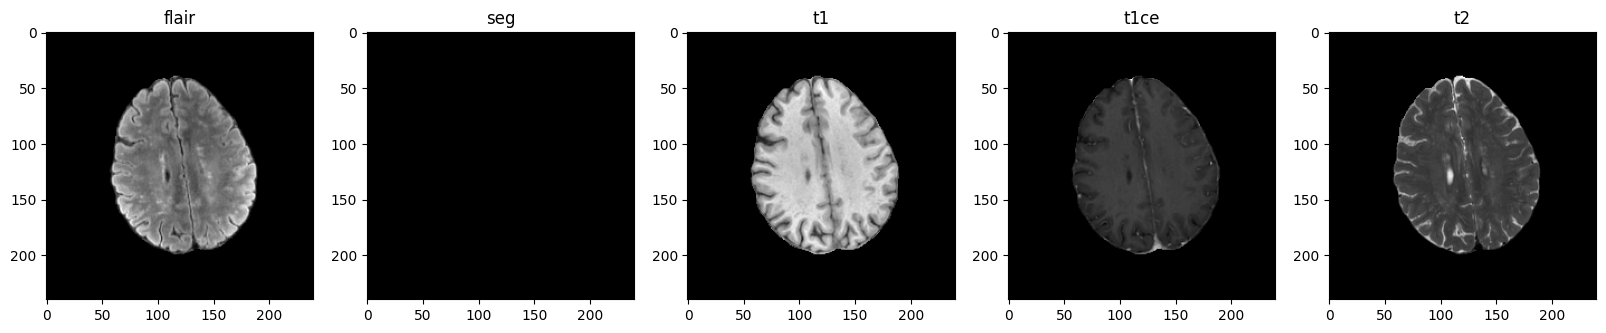

In [ ]:
plt.rcParams['figure.figsize'] = (20,20)
for i,name in enumerate(['flair', 'seg', 't1', 't1ce', 't2'],1):
    image = sitk.ReadImage('/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/MRI/BraTS2021_00621_{}.nii.gz'.format(name))
    img_arr = sitk.GetArrayFromImage(image)
    print(name, '  ', img_arr.shape)
    im = np.squeeze(img_arr[100])

    plt.subplot(1,5,i)
    plt.imshow(im, cmap='gray')
    plt.title(name)

flair    (155, 240, 240)
seg    (155, 240, 240)
t1    (155, 240, 240)
t1ce    (155, 240, 240)
t2    (155, 240, 240)


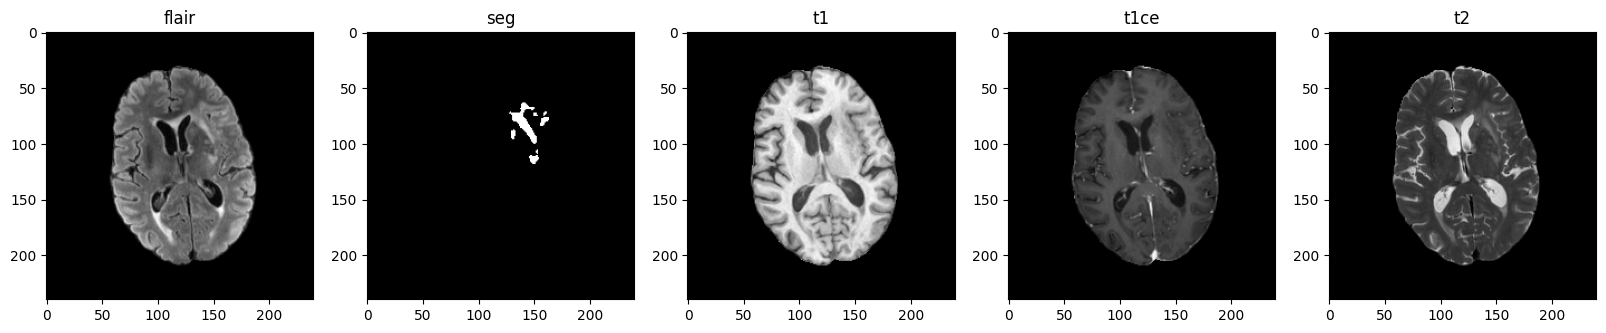

In [ ]:
plt.rcParams['figure.figsize'] = (20,20)
for i,name in enumerate(['flair', 'seg', 't1', 't1ce', 't2'],1):
    image = sitk.ReadImage('/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/MRI/BraTS2021_00621_{}.nii.gz'.format(name))
    img_arr = sitk.GetArrayFromImage(image)
    print(name, '  ', img_arr.shape)
    im = np.squeeze(img_arr[80])

    plt.subplot(1,5,i)
    plt.imshow(im, cmap='gray')
    plt.title(name)

(240, 240, 155)


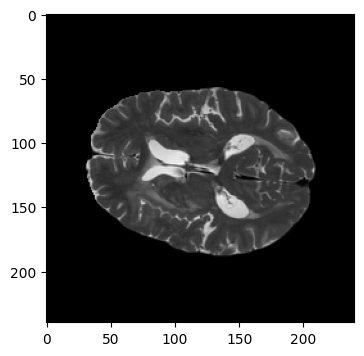

In [ ]:
plt.rcParams['figure.figsize'] = (4,4)
nii_img  = nib.load('/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/MRI/BraTS2021_00621_t2.nii.gz').get_fdata()
print(nii_img.shape)
plt.imshow(nii_img[:,:,80], cmap='gray')

(240, 240, 155)


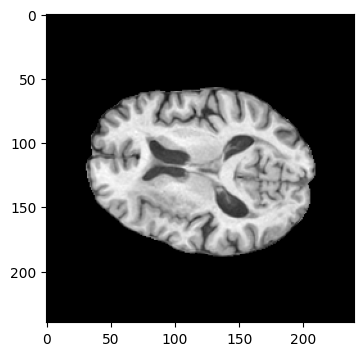

In [ ]:
plt.rcParams['figure.figsize'] = (4,4)
nii_img  = nib.load('/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/MRI/BraTS2021_00621_t1.nii.gz').get_fdata()
print(nii_img.shape)
plt.imshow(nii_img[:,:,80], cmap='gray')

In [ ]:
import nibabel as nib
import os
import albumentations as A
import numpy as np


class ImageReader:
    def __init__(
        self, root:str, img_size:int=256,
        normalize:bool=False, single_class:bool=False
    ) -> None:
        pad_size = 256 if img_size > 256 else 224
        self.resize = A.Compose(
            [
                A.PadIfNeeded(min_height=pad_size, min_width=pad_size, value=0),
                A.Resize(img_size, img_size)
            ]
        )
        self.normalize=normalize
        self.single_class=single_class
        self.root=root

    def read_file(self, path:str) -> dict:
        scan_type = path.split('_')[-1]
        raw_image = nib.load(path).get_fdata()
        raw_mask = nib.load(path.replace(scan_type, 'seg.nii.gz')).get_fdata()
        processed_frames, processed_masks = [], []
        for frame_idx in range(raw_image.shape[2]):
            frame = raw_image[:, :, frame_idx]
            mask = raw_mask[:, :, frame_idx]
            resized = self.resize(image=frame, mask=mask)
            processed_frames.append(resized['image'])
            processed_masks.append(
                1*(resized['mask'] > 0) if self.single_class else resized['mask']
            )
        scan_data = np.stack(processed_frames, 0)
        if self.normalize:
            if scan_data.max() > 0:
                scan_data = scan_data/scan_data.max()
            scan_data = scan_data.astype(np.float32)
        return {
            'scan': scan_data,
            'segmentation': np.stack(processed_masks, 0),
            'orig_shape': raw_image.shape
        }

    def load_patient_scan(self, idx:int, scan_type:str='flair') -> dict:
        patient_id = str(idx).zfill(5)
        scan_filename = f'/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/MRI/BraTS2021_00621_t1.nii.gz'
        return self.read_file(scan_filename)

In [ ]:
reader = ImageReader('/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/MRI',
                     img_size=128, normalize=True, single_class=False)
reader

In [ ]:
from skimage.morphology import binary_closing
import plotly.express as px
# Sử dụng thư viện Plotly Express để show ảnh -> code ngắn, tương tác dễ
# Có thể tương tác trực tiếp với ảnh đã show ra, ví dụ bên dưới, hãy đưa chuột vào ảnh

data = reader.load_patient_scan(0)

image = data['scan'][60]
masked_image = 1 * (image > 0)
filled_image = 1 * binary_closing(image)

px.imshow(
    np.array([image, masked_image, filled_image]),
    facet_col=0, title="Ảnh mask khác nhau - không có, ngưỡng và binary_closing",
)

In [ ]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/MICCAI_BraTS2020_TrainingData/'
def show_imgs(paths, i, class_):
    sub_path = sorted(os.listdir(TRAIN_DATASET_PATH + paths[i]))

    image_flair = nib.load(TRAIN_DATASET_PATH + paths[i]+ '/' + sub_path[0]).get_fdata()
    mask = nib.load(TRAIN_DATASET_PATH + paths[i]+ '/' + sub_path[1]).get_fdata()
    image_t1 = nib.load(TRAIN_DATASET_PATH + paths[i]+ '/' + sub_path[2]).get_fdata()
    image_t1ce = nib.load(TRAIN_DATASET_PATH + paths[i]+ '/' + sub_path[3]).get_fdata()
    image_t2 = nib.load(TRAIN_DATASET_PATH + paths[i]+ '/' + sub_path[4]).get_fdata()

    print('___________________________', class_ , '________________________')
    print(f"Chiều cao: {image_flair.shape[0]}")
    print(f"Chiều rộng: {image_flair.shape[1]}")
    print(f"Số lát cắt 2D: {image_flair.shape[-1]}")
    print()

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
    slice_w = 25
    ax4.imshow(image_flair[:,:,image_flair.shape[0]//2-slice_w])
    ax4.set_title('Flair')
    ax4.axis(False)
    ax1.imshow(image_t1[:,:,image_t1.shape[0]//2-slice_w])
    ax1.set_title('T1')
    ax1.axis(False)
    ax2.imshow(image_t1ce[:,:,image_t1ce.shape[0]//2-slice_w])
    ax2.set_title('T1CE')
    ax2.axis(False)
    ax3.imshow(image_t2[:,:,image_t2.shape[0]//2-slice_w])
    ax3.set_title('T2')
    ax3.axis(False)
    ax5.imshow(image_flair[:,:,image_flair.shape[0]//2-slice_w], cmap="OrRd", alpha=1.0)
    ax5.imshow(mask[:,:,mask.shape[0]//2-slice_w], alpha=0.2, cmap="OrRd")
    ax5.set_title('Mask')
    ax5.axis(False)
    plt.show()

___________________________ Có khối u ________________________
Chiều cao: 240
Chiều rộng: 240
Số lát cắt 2D: 155



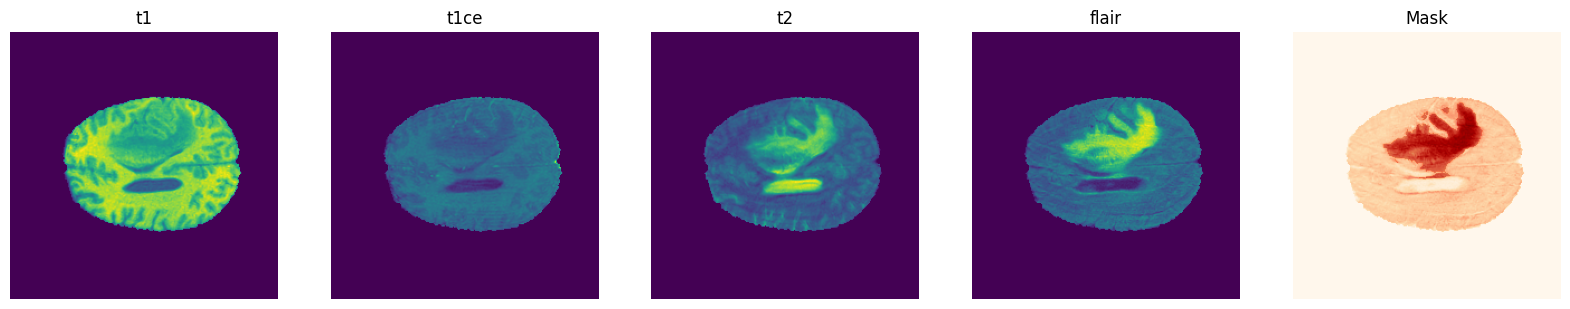

___________________________ Không có khối u ________________________
Chiều cao: 240
Chiều rộng: 240
Số lát cắt 2D: 155



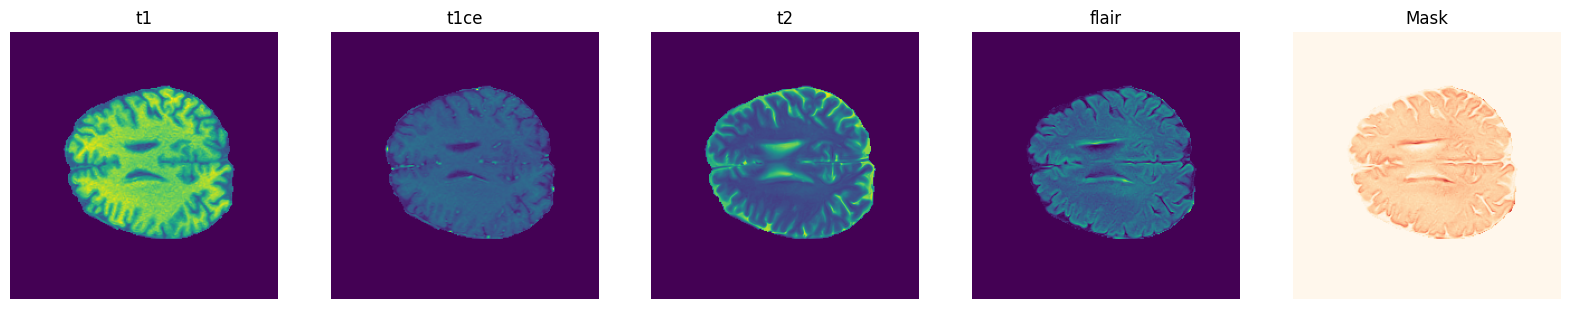

In [ ]:
path = sorted(os.listdir(r"/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/MICCAI_BraTS2020_TrainingData/"))
show_imgs(path, 0, 'Có khối u')
show_imgs(path, 100, 'Không có khối u')

In [ ]:
import cv2
import numpy as np
import glob
import PIL
import shutil
import tensorflow as tf
import nibabel as nib
import albumentations as A
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
images_path = '/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

data_path = [f.path for f in os.scandir(images_path ) if f.is_dir()]

def data_list(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

data_id = data_list(data_path);


train_, val_ = train_test_split(data_id,test_size=0.2)
train_files, test_files = train_test_split(train_,test_size=0.15)

## Train

In [ ]:
!pip install nilearn

In [ ]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif
# import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss



# define per class evaluation of dice coef
# https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include

In [ ]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

In [ ]:
IMG_SIZE=128

In [ ]:

def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4),
                         dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,
                         dice_coef_enhancing] )

In [ ]:
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

In [ ]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

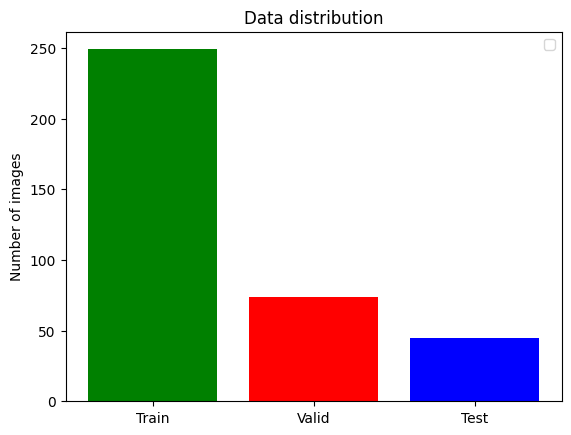

In [ ]:
# show number of data for each dir
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()

showDataLayout()

### Add call back

In [ ]:
csv_logger = CSVLogger('/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Code/training.log', separator=',', append=False)
callbacks = [ keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1), csv_logger]

In [ ]:
K.clear_session()

history =  model.fit(training_generator,
                    epochs=3,
                    validation_data = valid_generator)
model.save("/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Code/model.h5")

In [ ]:
hist=history.history
############### ########## ####### #######

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

### Prediction examples

In [ ]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')


4/4 [==============================] - 3s 285ms/step


<Figure size 1800x5000 with 0 Axes>

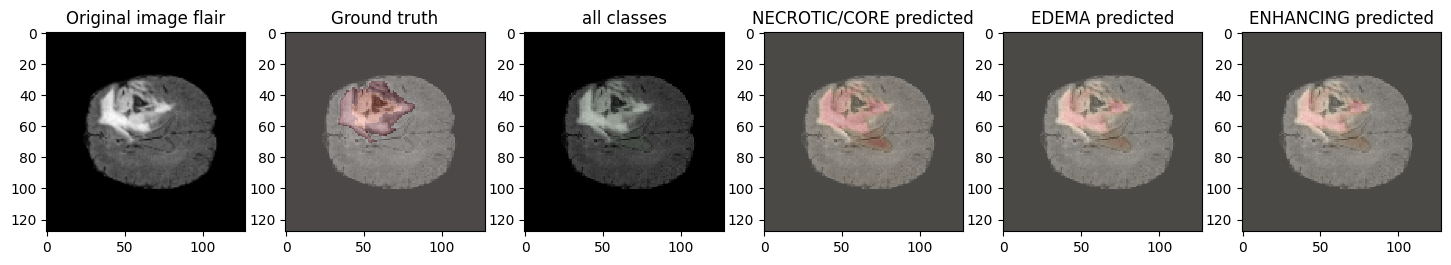

4/4 [==============================] - 0s 72ms/step


<Figure size 1800x5000 with 0 Axes>

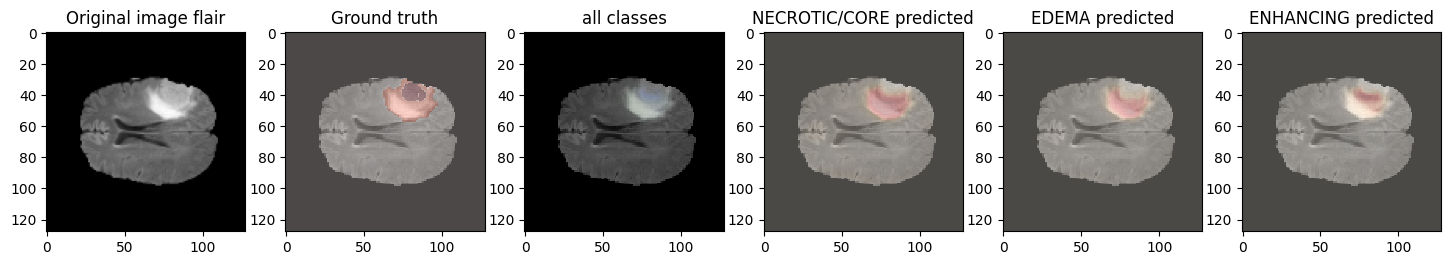

4/4 [==============================] - 0s 63ms/step


<Figure size 1800x5000 with 0 Axes>

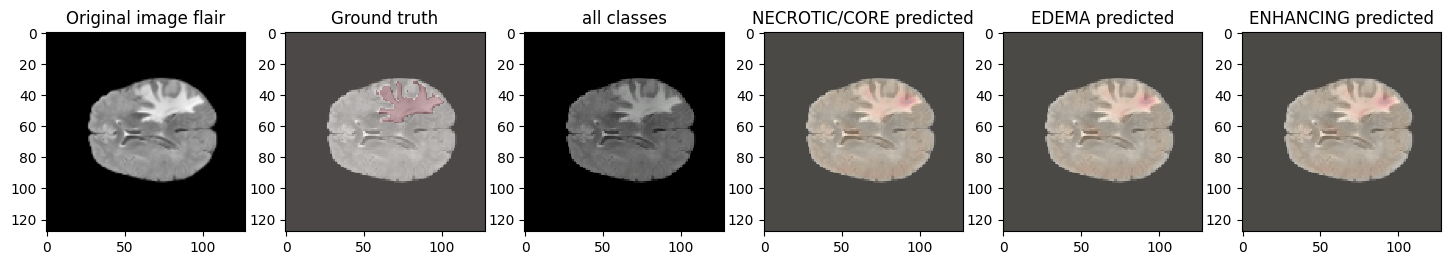

4/4 [==============================] - 0s 69ms/step


<Figure size 1800x5000 with 0 Axes>

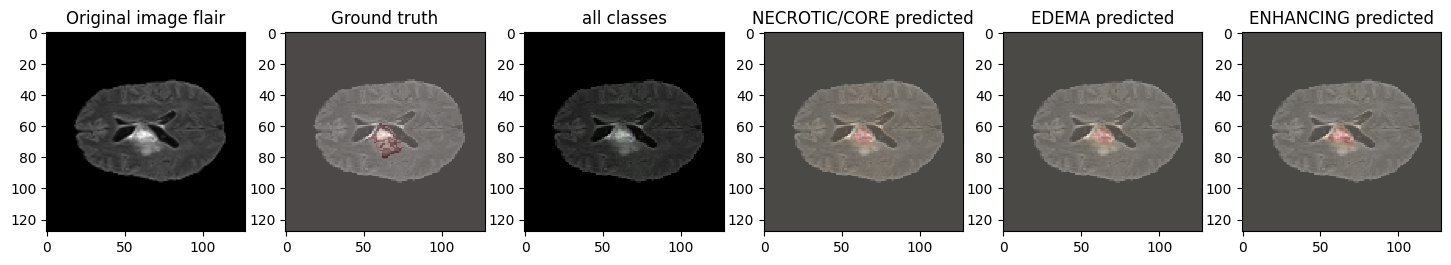

4/4 [==============================] - 0s 71ms/step


<Figure size 1800x5000 with 0 Axes>

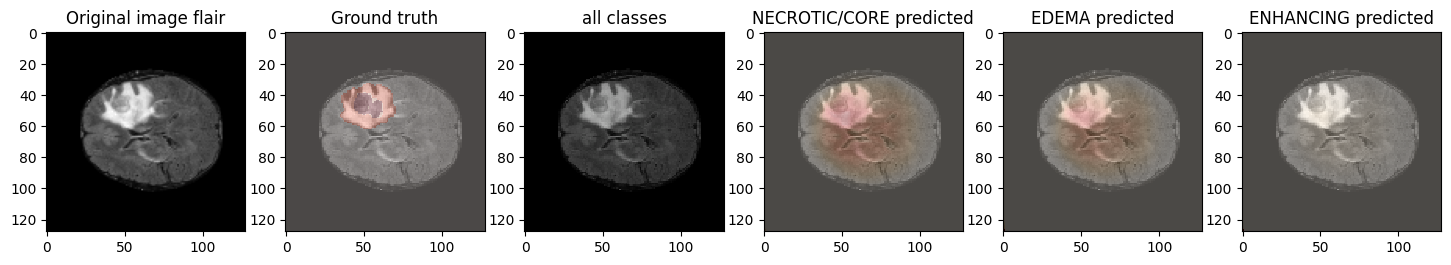

4/4 [==============================] - 0s 72ms/step


<Figure size 1800x5000 with 0 Axes>

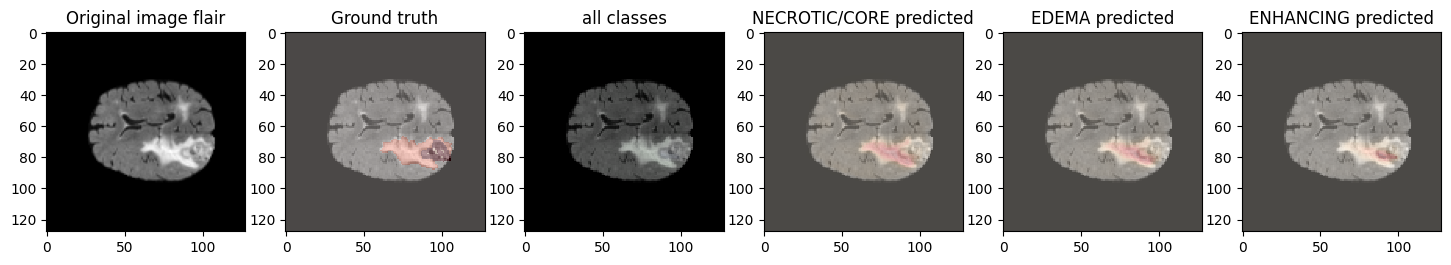

4/4 [==============================] - 0s 69ms/step


<Figure size 1800x5000 with 0 Axes>

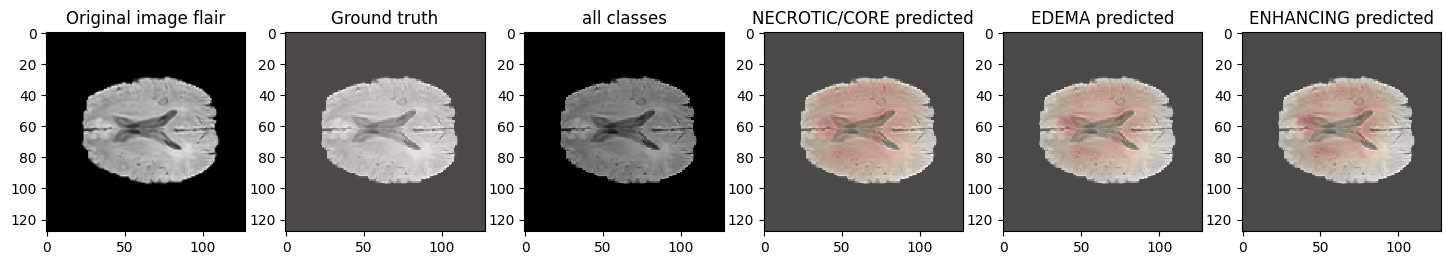

In [ ]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata()



    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()


showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])


### Eval

In [ ]:
case = case = test_ids[2][-3:]
path = f"/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)


core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'



gt[gt != eval_class] = 1 # use only one class for per class evaluation

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision,
                         sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

In [ ]:
from keras.models import load_model
from keras.metrics import MeanIoU

In [ ]:

batch_size = 2

test_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())